In [1]:
!pip install holidays

In [2]:
spark

# Set Up

In [3]:
import pandas as pd
from google.cloud import storage
from io import BytesIO
from datetime import datetime, date
import matplotlib.pyplot as plt
import holidays

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnan, when, count, udf, to_date, year, month, date_format, size, split, dayofweek
from pyspark.sql import functions as F
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler, MinMaxScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml import Pipeline




In [4]:
bucket_name = 'my-bigdataproject-jg'
gs_path  = f'gs://{bucket_name}/'
cleaned_folder = 'cleaned/'
destination_folder = 'code_and_models/'

storage_client = storage.Client() 
bucket = storage_client.get_bucket(bucket_name)

# Weather DF

In [5]:
weather_files = gs_path + cleaned_folder + 'weather_data_*.parquet'
weather_df = spark.read.parquet(weather_files)

"""
Drop columns:
tempmax
tempmin
feelslikemax
feelslikemin
preciptype
cloudcover

visibility
humidity

Keep columns:
datetime
borough

temp
feelslike
precip
snow
snowdepth
windspeed
uvindex
conditions
"""

weather_df = weather_df.drop('tempmax', 'tempmin', 'feelslikemax', 'feelslikemin', 'preciptype', 'cloudcover', 'visibility', 'humidity')

weather_df = weather_df.withColumnRenamed('borough', 'weather_borough')
weather_df = weather_df.withColumnRenamed('snow', 'snow_precip')

weather_df.printSchema()

root
 |-- datetime: string (nullable = true)
 |-- temp: double (nullable = true)
 |-- feelslike: double (nullable = true)
 |-- precip: double (nullable = true)
 |-- snow_precip: double (nullable = true)
 |-- snowdepth: double (nullable = true)
 |-- windspeed: double (nullable = true)
 |-- uvindex: long (nullable = true)
 |-- conditions: string (nullable = true)
 |-- weather_borough: string (nullable = true)



In [6]:
# Show me summary statistics for temp, feelslike, precip, snow_precip, snowdepth, windspeed, uvindex
weather_df.select('temp', 'feelslike', 'precip', 'snow_precip', 'snowdepth', 'windspeed', 'uvindex').summary().show()

24/12/04 00:14:21 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+------------------+-----------------+-------------------+-------------------+-------------------+-----------------+-----------------+
|summary|              temp|        feelslike|             precip|        snow_precip|          snowdepth|        windspeed|          uvindex|
+-------+------------------+-----------------+-------------------+-------------------+-------------------+-----------------+-----------------+
|  count|              5475|             5475|               5475|               5475|               5475|             5475|             5475|
|   mean| 57.17919634703195|55.23545205479445|0.12681570776255707|0.03786301369863015|0.11643835616438351|14.15684018264841|5.686027397260274|
| stddev|16.273021692774368|19.23574328297584|0.37855930890161854| 0.3077078853750881| 0.7482338903611033|4.747084010340972| 2.64903871604182|
|    min|              11.2|             -7.7|                0.0|                0.0|                0.0|              4.0|                0|

# Taxi Trips DF

In [7]:
taxi_files = gs_path + cleaned_folder + "taxi_data/*.parquet"
taxi_df = spark.read.parquet(taxi_files)
taxi_df.printSchema()

root
 |-- pickup_datetime: timestamp_ntz (nullable = true)
 |-- dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- tip_percentage: double (nullable = true)



In [8]:
# create a new column pickup_date, which the date using the pickup_datetime column
taxi_df = taxi_df.withColumn('pickup_date', to_date(col('pickup_datetime')))


# Create hour_of_day column from pickup_datetime
taxi_df = taxi_df.withColumn('hour_of_day', F.hour(col('pickup_datetime')))
# Create a time_of_day column based on hour_of_day
taxi_df = taxi_df.withColumn('time_of_day', when((col('hour_of_day') >= 5) & (col('hour_of_day') < 12), 'Morning').when((col('hour_of_day') >= 12) & (col('hour_of_day') < 21), 'Afternoon').otherwise('Night'))
# Show the number of records for each unique time_of_day
taxi_df.groupBy('time_of_day').count().show()



+-----------+--------+
|time_of_day|   count|
+-----------+--------+
|  Afternoon|59396803|
|      Night|21683603|
|    Morning|24465906|
+-----------+--------+



In [9]:
# Create a new column, group_size, based on the number of passengers
# group_size is 1 if num_passengers is 1
# group_size is 2 if num_passengers is 2
# group_size is 3 if num_passengers is greater than 3
taxi_df = taxi_df.withColumn('group_size', when(col('passenger_count') == 1, 1).when(col('passenger_count') == 2, 2).otherwise(3))

# Show the number of records for each unique group_size
taxi_df.groupBy('group_size').count().show()


+----------+--------+
|group_size|   count|
+----------+--------+
|         1|75459398|
|         3|14622979|
|         2|15463935|
+----------+--------+



In [10]:
# Remove the records with RatecodeID = 99 
taxi_df = taxi_df.filter(col('RatecodeID') != 99)

# Remove the records passenger_count = 0
taxi_df = taxi_df.filter(col('passenger_count') != 0)

# Remove the records with fare_amount < 3.70 (minimum fare amount)
taxi_df = taxi_df.filter(col('fare_amount') >= 3.70)

# Remove the records with total_amount <= 4.20 (minimum total amount)
taxi_df = taxi_df.filter(col('total_amount') > 4.20)

# Remove the records with trip_distance < 1/5 mile
taxi_df = taxi_df.filter((col('trip_distance') >= 0.2) & (col('trip_distance') <= 45))

# Round the tip_percentage to 2 decimal places
taxi_df = taxi_df.withColumn('tip_percentage', F.round(col('tip_percentage'), 2))


taxi_df = taxi_df.drop('dropoff_datetime', 'RatecodeID', 'payment_type', 'total_amount', 'pickup_datetime', 'tip_amount', 'hour_of_day')


# Taxi Zone DF

In [11]:
taxi_zone_file = gs_path + cleaned_folder + 'taxi_zones_data.parquet'
taxi_zone_df = spark.read.parquet(taxi_zone_file)
taxi_zone_df = taxi_zone_df.drop('zone')
taxi_zone_df.printSchema()


root
 |-- LocationID: long (nullable = true)
 |-- borough: string (nullable = true)



## Taxi data frames combined

In [12]:
# PU Location join
taxi_df = taxi_df.join(taxi_zone_df, taxi_df.PULocationID == taxi_zone_df.LocationID, how='left')


taxi_df = taxi_df.withColumnRenamed('Borough', 'PUBorough')
taxi_df = taxi_df.drop('LocationID')

# DO Location join
taxi_df = taxi_df.join(taxi_zone_df, taxi_df.DOLocationID == taxi_zone_df.LocationID, how='left')

taxi_df = taxi_df.withColumnRenamed('Borough', 'DOBorough')
taxi_df = taxi_df.drop('LocationID')

# Drop the PULocationID and DOLocationID columns
taxi_df = taxi_df.drop('PULocationID', 'DOLocationID')

# Drop the records where the PUBorough or DOBorough is 'EWR'
taxi_df = taxi_df.filter((taxi_df.PUBorough != 'EWR'))
taxi_df = taxi_df.filter((taxi_df.DOBorough != 'EWR'))

taxi_df.printSchema()

root
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- tip_percentage: double (nullable = true)
 |-- pickup_date: date (nullable = true)
 |-- time_of_day: string (nullable = false)
 |-- group_size: integer (nullable = false)
 |-- PUBorough: string (nullable = true)
 |-- DOBorough: string (nullable = true)



# Combined Data Frame

In [13]:
combined_df = taxi_df.join(weather_df, [taxi_df.pickup_date == weather_df.datetime, taxi_df.PUBorough == weather_df.weather_borough])

combined_df = combined_df.drop('datetime')
combined_df = combined_df.drop('weather_borough')

combined_df.printSchema()


root
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- tip_percentage: double (nullable = true)
 |-- pickup_date: date (nullable = true)
 |-- time_of_day: string (nullable = false)
 |-- group_size: integer (nullable = false)
 |-- PUBorough: string (nullable = true)
 |-- DOBorough: string (nullable = true)
 |-- temp: double (nullable = true)
 |-- feelslike: double (nullable = true)
 |-- precip: double (nullable = true)
 |-- snow_precip: double (nullable = true)
 |-- snowdepth: double (nullable = true)
 |-- windspeed: double (nullable = true)
 |-- uvindex: long (nullable = true)
 |-- conditions: string (nullable = true)



In [14]:
# Summarize the columns: tip_percentage, trip_distance, fare_amount, passenger_count
combined_df.select('tip_percentage', 'trip_distance', 'fare_amount', 'passenger_count').summary().show()

+-------+------------------+-----------------+------------------+------------------+
|summary|    tip_percentage|    trip_distance|       fare_amount|   passenger_count|
+-------+------------------+-----------------+------------------+------------------+
|  count|          97396100|         97396100|          97396100|          97396100|
|   mean|12.140664593522418|3.305880956526879|15.443503129178547|1.4280359377839564|
| stddev|   7.6899167944327|4.095159301490462|13.189977173150398|0.9526656644157758|
|    min|               0.0|              0.2|               3.7|                 1|
|    25%|              5.95|             1.11|               7.5|                 1|
|    50%|             16.61|             1.83|              11.0|                 1|
|    75%|             16.67|             3.33|              17.0|                 1|
|    max|             95.62|             45.0|             248.0|                 7|
+-------+------------------+-----------------+------------------+

# Tip Label

In [15]:
# Tip Class column
# When tip_percentage >= 15, tip_class is 1, otherwise 0
combined_df = combined_df.withColumn('tip_class', when(col('tip_percentage') >= 15, 1).otherwise(0))

# Show the number of records for each unqiue tip_class
combined_df.groupBy('tip_class').count().show()


+---------+--------+
|tip_class|   count|
+---------+--------+
|        1|55964222|
|        0|41431878|
+---------+--------+



# Datetime features

In [16]:
# datetime

# month
combined_df = combined_df.withColumn('month', month(col('pickup_date')))
# dayofweek
combined_df = combined_df.withColumn('dayofweek', dayofweek(col('pickup_date')))

# weekend
combined_df = combined_df.withColumn('weekend', when(col('dayofweek') == 1, 1.0).when(col('dayofweek') == 7, 1.0).otherwise(0))

# holiday
combined_df = combined_df.withColumn('pickup_date', to_date(col('pickup_date')))

# Get the min and max date in the datetime column
min_date = combined_df.agg({"pickup_date": "min"}).collect()[0][0]
max_date = combined_df.agg({"pickup_date": "max"}).collect()[0][0]


# Get the holidays observed in New York
us_holidays = holidays.UnitedStates(years=[min_date.year, max_date.year], observed=True, subdiv='NY')

#print(us_holidays)

# Keep only the dates of the holidays
us_holidays = list(us_holidays.keys())

# Create a new column holiday and set it to 1 if the date is a holiday, 0 otherwise
combined_df = combined_df.withColumn('holiday', when(col('pickup_date').isin(us_holidays), 1).otherwise(0))

# UDF Condition Features

In [17]:

# Or we can use the list ['Rain', 'Snow', 'Clear', 'Ice']
conditions = ['Rain', 'Snow', 'Clear', 'Ice']

# Create a new column for each condition
for condition in conditions:
    combined_df = combined_df.withColumn(condition, when(col('conditions').contains(condition), 1).otherwise(0))


# Pipeline

## String Indexer

In [18]:
# String Index columns
indexer_input = ['PUBorough', 'DOBorough', 'time_of_day']
indexer_output = [x + '_index' for x in indexer_input]
indexer = StringIndexer(inputCols=indexer_input, outputCols=indexer_output)


## One Hot Encoder

In [19]:
encoder_output = [x + '_encoded' for x in indexer_input]
encoder = OneHotEncoder(inputCols=indexer_output, outputCols=encoder_output)

# Min Max Scaler

In [20]:
columns_to_scale =[
    'temp',
    'feelslike',
    'precip',
    'snow_precip',
    'snowdepth',
    'windspeed',
    'uvindex'
]

# assembler for scaling
assembler_to_scale = VectorAssembler(inputCols=columns_to_scale, outputCol='features_to_scale')

# MinMaxScaler
scaler = MinMaxScaler(inputCol='features_to_scale', outputCol='scaled_features')

## Final Vector Assembler

In [21]:
"""
temp
feelslike
precip
snow
snowdepth
windspeed
uvindex
conditions
 'month', 'dayofweek', 'weekend', 'holiday', 'trip_distance', 'group_size', 'fare_amount'
"""

assemble_directly = [
    'month',
    'dayofweek',
    'weekend',
    'holiday',
    'trip_distance',
    'group_size',
    'fare_amount'
]


input_cols =  encoder_output + assemble_directly + conditions + ['scaled_features']
print(input_cols)

['PUBorough_encoded', 'DOBorough_encoded', 'time_of_day_encoded', 'month', 'dayofweek', 'weekend', 'holiday', 'trip_distance', 'group_size', 'fare_amount', 'Rain', 'Snow', 'Clear', 'Ice', 'scaled_features']


In [22]:
assembler = VectorAssembler(inputCols=input_cols, outputCol='features')

# Save the pipeline with features

In [23]:
print('Saving the transformed data...')
# Create a new frame with the transformed data
pipeline = Pipeline(stages=[indexer, encoder, assembler_to_scale, scaler, assembler])
model = pipeline.fit(combined_df)
transformed_df = model.transform(combined_df)

# Save the transformed data
transformed_df.write.parquet(gs_path + destination_folder + 'features', mode='overwrite')
print('Transformed data saved!')

Saving the transformed data...


Transformed data saved!


# Train / Test

In [24]:
train_df, test_df = combined_df.randomSplit([0.7, 0.3], seed=42)

# Pipeline  

In [25]:
lr = LogisticRegression(featuresCol='features', labelCol='tip_class', maxIter=10, regParam=0.1, elasticNetParam=0.8)

In [26]:
lr_pipeline = Pipeline(stages=[
    indexer,
    encoder,
    assembler_to_scale,
    scaler,
    assembler,
    lr
])

# Cross validating

In [27]:
grid = ParamGridBuilder()
grid = grid.addGrid(lr.regParam, [0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
grid = grid.addGrid(lr.elasticNetParam, [0, 0.5, 1])
grid = grid.build()

print('Number of models to be tested: ', len(grid))

# Binary classification evaluator with area under ROC as the metric
evaluator = BinaryClassificationEvaluator(labelCol='tip_class', metricName='areaUnderROC')


cv = CrossValidator(
    estimator=lr_pipeline,
    estimatorParamMaps=grid,
    evaluator=evaluator,
    numFolds=3
)

all_models = cv.fit(train_df)



Number of models to be tested:  18


In [28]:
# predictions
predictions = all_models.transform(test_df)

# Calculate the AUC
auc = evaluator.evaluate(predictions)

print(f"AUC: {auc}")

# Create a confusion matrix
predictions.groupby('tip_class', 'prediction').count().show()
cm = predictions.groupby('tip_class').pivot('prediction').count().fillna(0).collect()

def calculate_metrics(cm):
    tn = cm[0][1]                # True Negative
    fp = cm[0][2]                # False Positive
    fn = cm[1][1]                # False Negative
    tp = cm[1][2]                # True Positive
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * (precision * recall) / (precision + recall)
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = calculate_metrics(cm)
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

AUC: 0.5239737326719903


+---------+----------+--------+
|tip_class|prediction|   count|
+---------+----------+--------+
|        1|       1.0|16432056|
|        0|       0.0|  563152|
|        0|       1.0|11863179|
|        1|       0.0|  361321|
+---------+----------+--------+



Accuracy: 0.4183648926265793
Precision: 0.41926419766437706
Recall: 0.9546807500942958
F1 Score: 0.5826484669081734


Best Model Stages: 
[StringIndexerModel: uid=StringIndexer_3dd4373591bf, handleInvalid=error, numInputCols=3, numOutputCols=3, OneHotEncoderModel: uid=OneHotEncoder_e7f158ac09eb, dropLast=true, handleInvalid=error, numInputCols=3, numOutputCols=3, VectorAssembler_e727697f3128, MinMaxScalerModel: uid=MinMaxScaler_35bcfb89073d, numFeatures=7, min=0.0, max=1.0, VectorAssembler_06a37f31975a, LogisticRegressionModel: uid=LogisticRegression_d96965a953da, numClasses=2, numFeatures=28]


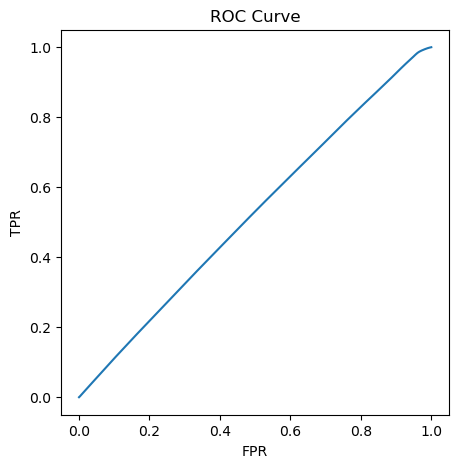

In [29]:
# Best model 
best_model = all_models.bestModel

print(f"Best Model Stages: \n{best_model.stages}")

# Parameters of the best model
best_model.stages[-1].extractParamMap()

# Create a ROC curve
trainingSummary = best_model.stages[-1].summary

plt.figure(figsize=(5, 5))
plt.plot(trainingSummary.roc.select('FPR').collect(),
         trainingSummary.roc.select('TPR').collect())
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.show()


In [30]:
coefficients = best_model.stages[-1].coefficients
# Print the name of the features and their corresponding coefficients
for i, col in enumerate(input_cols):
    print(f"{col}: {coefficients[i]}")
    

PUBorough_encoded: 0.1026303780587641
DOBorough_encoded: -0.08122394548668956
time_of_day_encoded: -0.14088124415205194
month: -1.3149578224643657
dayofweek: 0.17904632378444052
weekend: -0.19007534101300036
holiday: 0.11234116999779395
trip_distance: -1.1343788063732192
group_size: -0.07739401525212544
fare_amount: -0.11818837064487658
Rain: 0.005569633259161771
Snow: 0.0009186153852676726
Clear: -0.012358782562273194
Ice: -0.0440748465826581
scaled_features: 0.012158235286061591


# Save the Model

In [31]:
# Save the model
print('Saving the model')
model_path = gs_path + destination_folder + 'model'
best_model.write().overwrite().save(model_path)
print('Model saved')

Saving the model


Model saved
